# **0 Imports**

In [132]:
import pandas as pd
import numpy as np
from IPython.display import display

import plotly.express as px

## **0.1 Helper functions**

In [91]:
def week_of_month(x):
    if x == 1:
        return 'primeira'
    elif x == 2:
        return 'segunda'
    elif x == 3:
        return 'terceira'
    elif x == 4:
        return 'quarta'
    else:
        return 'quinta'

def dia_da_semana(df, nome_coluna_data):
    nomes_dias = {
        'Monday': 'segunda',
        'Tuesday': 'terca',
        'Wednesday': 'quarta',
        'Thursday': 'quinta',
        'Friday': 'sexta',
        'Saturday': 'sabado',
        'Sunday': 'domingo'}

    df['dia_da_semana'] = df[nome_coluna_data].dt.day_name().map(nomes_dias)
    
    return df

## **0.2 Load dataset**

In [92]:
item_pedido=pd.read_excel('../data/ITEM_PEDIDO-_2_ _.xlsx',index_col=0)
itens=pd.read_excel('../data/ITENS-_3___.xlsx',index_col=0)
pedido=pd.read_excel('../data/PEDIDO-_1__.xlsx',index_col=0)

# **1 Data description**

## **1.1 Df item_pedido**

In [93]:
display(item_pedido.head())

print(item_pedido.info(),'\n')

print(f"ID's únicos \n{len(item_pedido['ID_PEDIDO'].unique())}",'\n')

quantidades = item_pedido.groupby('ID_ITEM')['QUANTIDADE'].sum().reset_index()
display(quantidades)

print('\n'"Impressões: Alguns ID'S se repetem por conterem mais de um item no pedido e não existe uma diferença discrepante entre a quantidade por item")

,ID_PEDIDO,ID_ITEM,QUANTIDADE
0,120210601,item C,4
1,220210601,item A,3
2,320210604,item C,1
3,420210604,item B,4
4,420210604,item C,2


<class 'pandas.core.frame.DataFrame'>
Index: 295 entries, 0 to 294
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID_PEDIDO   295 non-null    int64 
 1   ID_ITEM     295 non-null    object
 2   QUANTIDADE  295 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 9.2+ KB
None 

ID's únicos 
181 



,ID_ITEM,QUANTIDADE
0,item A,211
1,item B,217
2,item C,216
3,item D,251



Impressões: Alguns ID'S se repetem por conterem mais de um item no pedido e não existe uma diferença discrepante entre a quantidade por item


## **1.2 Df pedido**

In [94]:
display(pedido.head())

print(pedido.info(),'\n')

print(f"ID's únicos \n{len(pedido['ID_PEDIDO'].unique())}",'\n')

pedido['DATA'] = pd.to_datetime(pedido['DATA'])

print(f"Data mínima {pedido['DATA'].min()} e data máxima {pedido['DATA'].max()}",'\n')

print('Impressões: O index possue ao todo 294 contagens, porém a tabela possue 181 linhas; possivelmente 113 linhas não foram imputadas por algum erro')
print('O intervalo das datas é de 3 meses')
print('A coluna VALOR_TOTAL não possue valores imputados')

,ID_PEDIDO,DATA,VALOR_TOTAL
0,120210601,2021-06-01,NaN
1,220210601,2021-06-01,NaN
2,320210604,2021-06-04,NaN
3,420210604,2021-06-04,NaN
5,520210604,2021-06-04,NaN


<class 'pandas.core.frame.DataFrame'>
Index: 181 entries, 0 to 293
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID_PEDIDO    181 non-null    int64  
 1   DATA         181 non-null    object 
 2   VALOR_TOTAL  0 non-null      float64
dtypes: float64(1), int64(1), object(1)
memory usage: 5.7+ KB
None 

ID's únicos 
181 

Data mínima 2021-06-01 00:00:00 e data máxima 2021-09-01 00:00:00 

Impressões: O index possue ao todo 294 contagens, porém a tabela possue 181 linhas; possivelmente 113 linhas não foram imputadas por algum erro
O intervalo das datas é de 3 meses
A coluna VALOR_TOTAL não possue valores imputados


## **1.3 Df itens**

In [95]:
display(itens)

print('Impressões: Aparenta ser o tipo de entregável esperado pela empresa')

,0
item A,10
item B,15
item C,20
item D,25


Impressões: Aparenta ser o tipo de entregável esperado pela empresa


# **2 Feature engineering**

In [96]:
# Estratégia: 

# unir a tabela item_pedido e pedido, de forma que a tabela final seja igual a tabela pedido,
# porém terá colunas adicionais referentes a todos os items vendidos em determinada data,
# agrupando todas as datas repetidas

## **2.1 Df merge**

In [97]:
# criando uma tabela auxiliar a partir da tabela 'item_pedido' com a coluna ID ITEM quebrada em quatro colunas para cada tipo de item
pivot_table = item_pedido.pivot_table(index='ID_PEDIDO', columns='ID_ITEM', values='QUANTIDADE', fill_value=0).reset_index()

# unindo a tabela 'pedido' com a tabela auxiliar através da coluna 'ID_PEDIDO'
pedido = pedido.merge(pivot_table[['ID_PEDIDO','item A', 'item B', 'item C', 'item D']], on='ID_PEDIDO', how='left')

# agrupando a tabela pedido pela coluna DATA a fim de ter a soma total de cada item por dia 
pedido_grouped = pedido.groupby('DATA').agg({'ID_PEDIDO': 'first',  # mantém o primeiro ID_PEDIDO
                                            'item A': 'sum',
                                            'item B': 'sum',
                                            'item C': 'sum',
                                            'item D': 'sum'}).reset_index()

# dropando coluna que não será utilizada 
pedido_grouped.drop(columns=['ID_PEDIDO'],inplace=True)

# alteração de nome
df=pedido_grouped
df

,DATA,item A,item B,item C,item D
0,2021-06-01,3.0,0.0,4.0,0.0
1,2021-06-04,0.0,6.0,3.0,1.0
2,2021-06-05,5.0,3.0,0.0,1.0
3,2021-06-06,0.0,8.0,4.0,0.0
4,2021-06-07,2.0,1.0,0.0,0.0
...,...,...,...,...,...
76,2021-08-28,1.0,0.0,1.0,4.0
77,2021-08-29,3.0,1.0,3.0,6.0
78,2021-08-30,4.0,0.0,0.0,3.0
79,2021-08-31,3.0,0.0,5.0,3.0


## **2.2 Change types**

In [98]:
df[['item A', 'item B', 'item C', 'item D']]=df[['item A', 'item B', 'item C', 'item D']].astype(int)

## **2.3 Rename columns**

In [99]:
df.rename(columns={'DATA':'data','item A':'item_a','item B':'item_b','item C':'item_c','item D':'item_d'},inplace=True)

## **2.4 Feature creation**

In [100]:
# soma total de cada item
df['itens_totais'] = df[['item_a', 'item_b', 'item_c', 'item_d']].sum(axis=1)

# dia da semana
df = dia_da_semana(df, 'data')

# tipo do dia
df['tipo_dia'] = df['data'].dt.weekday.apply(lambda x: 'util' if x < 5 else 'fds')

# semana do mês
df['semana_do_mes'] = df['data'].dt.day.apply(lambda x: week_of_month((x - 1) // 7 + 1))

df

,data,item_a,item_b,item_c,item_d,itens_totais,dia_da_semana,tipo_dia,semana_do_mes
0,2021-06-01,3,0,4,0,7,terca,util,primeira
1,2021-06-04,0,6,3,1,10,sexta,util,primeira
2,2021-06-05,5,3,0,1,9,sabado,fds,primeira
3,2021-06-06,0,8,4,0,12,domingo,fds,primeira
4,2021-06-07,2,1,0,0,3,segunda,util,primeira
...,...,...,...,...,...,...,...,...,...
76,2021-08-28,1,0,1,4,6,sabado,fds,quarta
77,2021-08-29,3,1,3,6,13,domingo,fds,quinta
78,2021-08-30,4,0,0,3,7,segunda,util,quinta
79,2021-08-31,3,0,5,3,11,terca,util,quinta


## **2.5 Data description**

In [130]:
cols = ['item_a', 'item_b', 'item_c', 'item_d']
desc = df[cols].describe().drop(['count', '25%', '50%', '75%'])
desc.loc['sum'] = df[cols].sum()
desc

,item_a,item_b,item_c,item_d
mean,2.506173,2.629630,2.481481,2.901235
std,2.145480,2.781387,2.434703,2.562250
min,0.000000,0.000000,0.000000,0.000000
max,9.000000,10.000000,9.000000,10.000000
sum,203.000000,213.000000,201.000000,235.000000


In [122]:
print(f"Data mínima {df['data'].min()} e máxima {df['data'].max()}",'\n')

print(f"Total de itens a: {df['item_a'].sum()}")
print(f"Total de itens b: {df['item_b'].sum()}")
print(f"Total de itens c: {df['item_c'].sum()}")
print(f"Total de itens d: {df['item_d'].sum()}",'\n')

print(f"Contagem de dias:\n{df['dia_da_semana'].value_counts().to_string(header=False)}",'\n')

print(f"Contagem de semanas do mês:\n{df['semana_do_mes'].value_counts().to_string(header=False)}",'\n')

Data mínima 2021-06-01 00:00:00 e máxima 2021-09-01 00:00:00 

Total de itens a: 203
Total de itens b: 213
Total de itens c: 201
Total de itens d: 235 

Contagem de dias:
sexta      13
sabado     13
domingo    13
terca      12
segunda    10
quarta     10
quinta     10 

Contagem de semanas do mês:
quarta      20
segunda     18
terceira    18
primeira    17
quinta       8 



# **3 EDA**

## **Univariate analysis**

In [131]:
print(f"Data mínima {df['data'].min()} e máxima {df['data'].max()}",'\n')

Data mínima 2021-06-01 00:00:00 e máxima 2021-09-01 00:00:00 



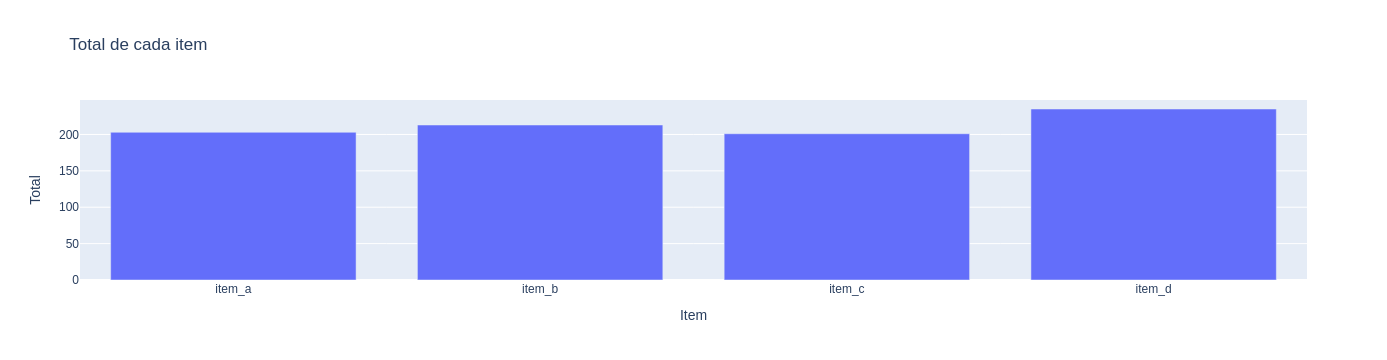

In [141]:
fig = px.bar(x=['item_a', 'item_b', 'item_c', 'item_d'],
             y=df[['item_a', 'item_b', 'item_c', 'item_d']].sum(),
             labels={'x': 'Item', 'y': 'Total'},
             title='Total de cada item'); fig.show()

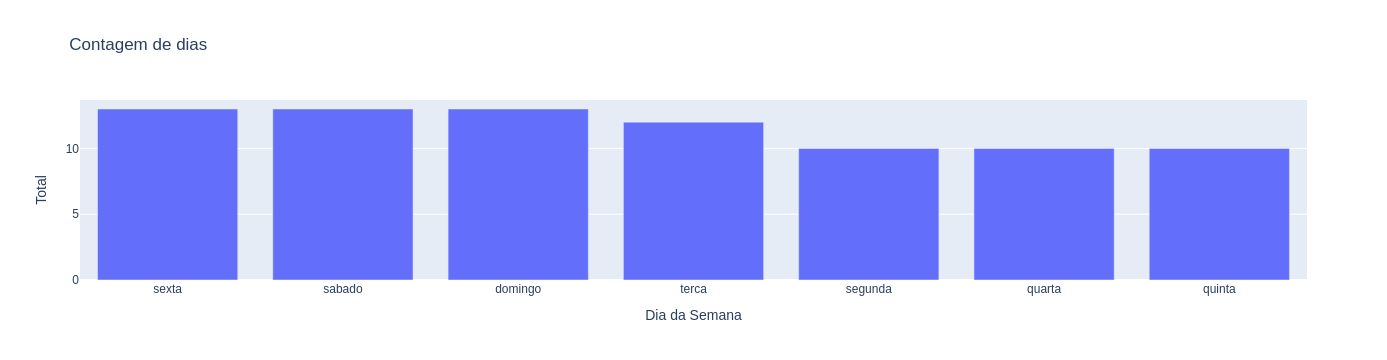

In [143]:
fig = px.bar(
    x=df['dia_da_semana'].value_counts().index,
    y=df['dia_da_semana'].value_counts().values,
    labels={'x': 'Dia da Semana', 'y': 'Total'},
    title='Contagem de dias'
); fig.show()

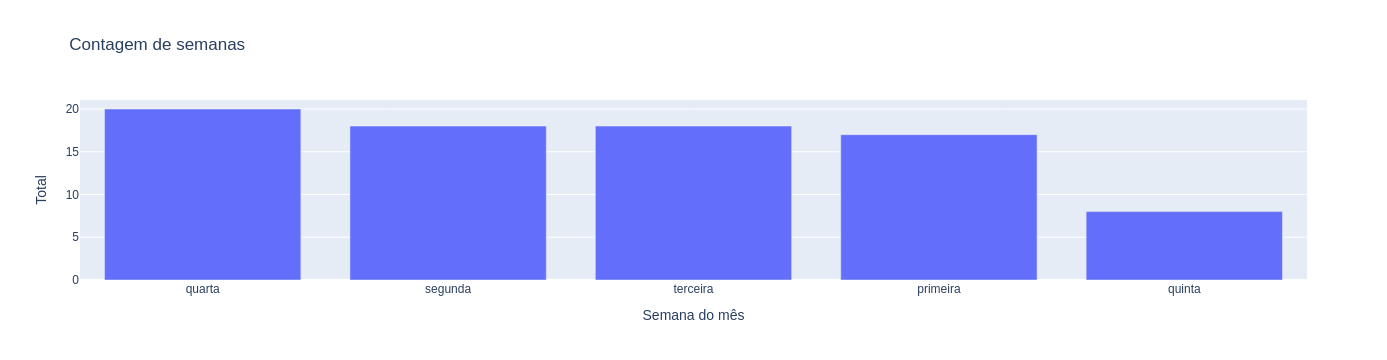

In [147]:
fig = px.bar(
    x=df['semana_do_mes'].value_counts().index,
    y=df['semana_do_mes'].value_counts().values,
    labels={'x': 'Semana do mês', 'y': 'Total'},
    title='Contagem de semanas'
); fig.show()

## **Bivariate analysis**

## **Hypothesis**

## **Segunda-feira vende-se 20% a menos em média**

## **Entre sexta a domingo, vende-se em média 30% a mais**

## **Do 15° dia até o 5° dia do mês seguinte, vende-se em média 40% a mais**

In [102]:
# possibilidades:

# implementar um algoritmo de time series para prever os 4 itens,
# ou tentar prever individualmente cada item usando os outros itens e as outras colunas como variáveis preditoras 
# caso aja relação entre os itens 
# a segunda provavelmente não é a mais ideal pq ignoraria a sazonalidade 